Some pictures and our coursework title here! Anyone has some ideas plz update here :)

# Introduction

## Background

## Objective

# Set up environment

In [1]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

import pyspark

number_cores = int(os.environ['NUM_CPUS'])
memory_gb = int(os.environ['AVAILABLE_MEMORY_MB']) // 1024
conf = (
    pyspark.SparkConf()
        .setMaster('local[{}]'.format(number_cores))
        .set('spark.driver.memory', '{}g'.format(memory_gb))
)
sc = pyspark.SparkContext(conf=conf)

In [2]:
print(sc)

<SparkContext master=local[4] appName=pyspark-shell>


In [3]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# Prepare the dataset

## Scraping

## Load dataset

In [4]:
# Load the dataset
indian = sqlContext.read.csv("/project/Project/DataEngineeringGroupAO/Recipe_dataset/data_indian.csv",header=True)
italian = sqlContext.read.csv("/project/Project/DataEngineeringGroupAO/Recipe_dataset/data_italian.csv",header=True)
mexican = sqlContext.read.csv("/project/Project/DataEngineeringGroupAO/Recipe_dataset/data_mexican.csv",header=True)
new_recipe = sqlContext.read.csv("/project/Project/DataEngineeringGroupAO/Recipe_dataset/final_scrape_not_cleaned.csv",header=True)

In [5]:
# See the size of the dataset
print('indian: ', indian.count(),' italian: ', italian.count(), ' mexican: ', mexican.count(),
     ' new_recipe: ', new_recipe.count())

indian:  480  italian:  400  mexican:  620  new_recipe:  2340


For the first three datasets, we do not have labels for them. We could use them as training set but three of them combined together is not enough. In this case, we decided to combine them together first, and then do splitting, and then remove the labels of training set. So, we have to first label the unlabelled dataset manually, which is shown as below.

In [6]:
# Label the data
from pyspark.sql.functions import lit

indian = indian.withColumn("label",lit("indian"))
italian = italian.withColumn("label",lit("italian"))
mexican = mexican.withColumn("label",lit("mexican"))

In [7]:
# Combine all datasets into one

from functools import reduce
from pyspark.sql import DataFrame

def unionAll(dfs):
    return reduce(DataFrame.unionAll, dfs)

dfs = [indian, italian, mexican, new_recipe]
recipe = unionAll(dfs)
recipe.show()

+--------------------+--------------------+------+
|               Title|         Description| label|
+--------------------+--------------------+------+
|  Indian Peanut Stew|This is an easy, ...|indian|
|        Roomali Roti|There is no leave...|indian|
|Spicy Sweet Potat...|It's important to...|indian|
|        Chicken Saag|The classic India...|indian|
|Paleo Slow Cooker...|Boneless pork loi...|indian|
|Bombay Chicken an...|Chicken parts are...|indian|
|Indian Carrots, P...|Potatoes, peas an...|indian|
|Wendy's Indian Bu...|This recipe resem...|indian|
|    Indian Chickpeas|Garbanzo beans, o...|indian|
|Dal Makhani (Indi...|These richly spic...|indian|
|               Raita|Chopped tomatoes ...|indian|
|Yogurt-Marinated ...|A yogurt-based ma...|indian|
|Indian-Spiced Roa...|Spicy roasted chi...|indian|
|Cauliflower and T...|Pressed tofu cube...|indian|
|Channa Masala (Ch...|This fantastic In...|indian|
|Bengali Chicken C...|Thy this deliciou...|indian|
|  Indian Sweet Bread|A crisp a

As these two scraping are from the same website, but using different method, there might be some duplicates in the combined datasets. We try to remove the duplicates before data cleaning.

In [11]:
# Size before removing duplicates
print(recipe.count())

3840


In [12]:
# Remove duplicates
recipe = recipe.dropDuplicates(["Title"])

In [13]:
# Size after dropping duplicates
print(recipe.count())

3793


# Data Cleaning

Now we come to the data cleaning part! Our dataset is all about **text**, and it needs to be transformed a bit for better analysis.

- Lowercase
- Remove punctuations and digits. 

In NLTK, we have packages which helps remove punctuations and digits, but in our case, we try to use **regular expression** to remove unwanted signs in our dataset.
- Remove stopwords
- Stemming the text 


In [8]:
# import all packages needed for data cleaning

from pyspark.sql.functions import udf, regexp_replace, lower, col
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem.snowball import SnowballStemmer
from pyspark.sql.types import IntegerType, ArrayType, StringType

In [9]:
# Lowercase

recipe = recipe.select(*[lower(col(col_name)).name(col_name) for col_name in recipe.columns])
recipe.show()

+--------------------+--------------------+------+
|               Title|         Description| label|
+--------------------+--------------------+------+
|  indian peanut stew|this is an easy, ...|indian|
|        roomali roti|there is no leave...|indian|
|spicy sweet potat...|it's important to...|indian|
|        chicken saag|the classic india...|indian|
|paleo slow cooker...|boneless pork loi...|indian|
|bombay chicken an...|chicken parts are...|indian|
|indian carrots, p...|potatoes, peas an...|indian|
|wendy's indian bu...|this recipe resem...|indian|
|    indian chickpeas|garbanzo beans, o...|indian|
|dal makhani (indi...|these richly spic...|indian|
|               raita|chopped tomatoes ...|indian|
|yogurt-marinated ...|a yogurt-based ma...|indian|
|indian-spiced roa...|spicy roasted chi...|indian|
|cauliflower and t...|pressed tofu cube...|indian|
|channa masala (ch...|this fantastic in...|indian|
|bengali chicken c...|thy this deliciou...|indian|
|  indian sweet bread|a crisp a

In [10]:
# Remove punctuation and digits

recipe_clean = recipe.select(regexp_replace('Title', "[^a-zA-Z\\s]", "").alias('title'), 
    (regexp_replace('Description', "[^a-zA-Z\\s]", "").alias('des')),'label')
recipe_clean.show()

+--------------------+--------------------+------+
|               title|                 des| label|
+--------------------+--------------------+------+
|  indian peanut stew|this is an easy a...|indian|
|        roomali roti|there is no leave...|indian|
|spicy sweet potat...|its important to ...|indian|
|        chicken saag|the classic india...|indian|
|paleo slow cooker...|boneless pork loi...|indian|
|bombay chicken an...|chicken parts are...|indian|
|indian carrots pe...|potatoes peas and...|indian|
|wendys indian but...|this recipe resem...|indian|
|    indian chickpeas|garbanzo beans on...|indian|
|dal makhani india...|these richly spic...|indian|
|               raita|chopped tomatoes ...|indian|
|yogurtmarinated s...|a yogurtbased mar...|indian|
|indianspiced roas...|spicy roasted chi...|indian|
|cauliflower and t...|pressed tofu cube...|indian|
|channa masala chi...|this fantastic in...|indian|
|bengali chicken c...|thy this deliciou...|indian|
|  indian sweet bread|a crisp a

In [11]:
# Remove Stopwords

# Tokenize text
tokenizer = Tokenizer(inputCol="des", outputCol="des_token")
recipe = tokenizer.transform(recipe_clean).select('title','des','des_token','label')
# tokenized.select("Description", "Des_words")\
    #.withColumn("tokens", countTokens(col("Des_words"))).show(truncate=False)

# Remove stopwords
remover = StopWordsRemover(inputCol='des_token', outputCol='des_clean')
recipe_no_stopw = remover.transform(recipe).select('title','des_clean', 'label')
recipe_no_stopw.show()

+--------------------+--------------------+------+
|               title|           des_clean| label|
+--------------------+--------------------+------+
|  indian peanut stew|[easy, authentic,...|indian|
|        roomali roti|[leavening, simpl...|indian|
|spicy sweet potat...|[important, use, ...|indian|
|        chicken saag|[classic, indian,...|indian|
|paleo slow cooker...|[boneless, pork, ...|indian|
|bombay chicken an...|[chicken, parts, ...|indian|
|indian carrots pe...|[potatoes, peas, ...|indian|
|wendys indian but...|[recipe, resemble...|indian|
|    indian chickpeas|[garbanzo, beans,...|indian|
|dal makhani india...|[richly, spiced, ...|indian|
|               raita|[chopped, tomatoe...|indian|
|yogurtmarinated s...|[yogurtbased, mar...|indian|
|indianspiced roas...|[spicy, roasted, ...|indian|
|cauliflower and t...|[pressed, tofu, c...|indian|
|channa masala chi...|[fantastic, india...|indian|
|bengali chicken c...|[thy, delicious, ...|indian|
|  indian sweet bread|[crisp, s

In [12]:
# Stem text
stemmer = SnowballStemmer(language='english')
stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
recipe = recipe_no_stopw.withColumn("des_stemmed", stemmer_udf("des_clean")).select('title', 'des_stemmed','label')
recipe.show()

+--------------------+--------------------+------+
|               title|         des_stemmed| label|
+--------------------+--------------------+------+
|  indian peanut stew|[easi, authent, d...|indian|
|        roomali roti|[leaven, simpl, t...|indian|
|spicy sweet potat...|[import, use, goo...|indian|
|        chicken saag|[classic, indian,...|indian|
|paleo slow cooker...|[boneless, pork, ...|indian|
|bombay chicken an...|[chicken, part, b...|indian|
|indian carrots pe...|[potato, pea, car...|indian|
|wendys indian but...|[recip, resembl, ...|indian|
|    indian chickpeas|[garbanzo, bean, ...|indian|
|dal makhani india...|[rich, spice, len...|indian|
|               raita|[chop, tomato, cu...|indian|
|yogurtmarinated s...|[yogurtbas, marin...|indian|
|indianspiced roas...|[spici, roast, ch...|indian|
|cauliflower and t...|[press, tofu, cub...|indian|
|channa masala chi...|[fantast, indian,...|indian|
|bengali chicken c...|[thi, delici, aut...|indian|
|  indian sweet bread|[crisp, s

# Data Splitting & Pattern Exploration

## Data Splitting

maxim's wording

In [13]:
# Filter out different recipes
# Create temp table
recipe.createOrReplaceTempView('recipes')

recipe_ind = sqlContext.sql("SELECT * FROM recipes WHERE label == 'indian'")
recipe_ita = sqlContext.sql("SELECT * FROM recipes WHERE label == 'italian'")
recipe_mex = sqlContext.sql("SELECT * FROM recipes WHERE label == 'mexican'")

In [14]:
# We asssume that we do not know labels for the majority of data points, 
# hence further explore only test split
recipe_ind_tr, recipe_ind_ts, recipe_ind_d,recipe_ind_v  = recipe_ind.randomSplit([0.6,0.2,0.1,0.1],seed = 11)
recipe_ita_tr, recipe_ita_ts, recipe_ita_d, recipe_ita_v = recipe_ita.randomSplit([0.6,0.2,0.1,0.1],seed = 11)
recipe_mex_tr, recipe_mex_ts, recipe_mex_d, recipe_mex_v = recipe_mex.randomSplit([0.6,0.2,0.1,0.1],seed = 11)

## Pattern Exploration

Before writing the label functions, we want to get our head around how our dataset look like and see if we can get some ideas from it for writing label functions.

Since we want to label the type of the recipe. We made a word frequency dataframe, which displays top 15 words in each type of the recipe to help us identify the keywords connected to each cuise.

In [15]:
# Create frequency list of description
import pyspark.sql.functions as f

top_n = 20

ind_counts = recipe_ind_d.select(f.explode('des_stemmed').alias('col')).groupBy('col').count()
ind_des_freq = ind_counts.orderBy(ind_counts["count"].desc()).limit(top_n)

ita_counts = recipe_ita_d.select(f.explode('des_stemmed').alias('col')).groupBy('col').count()
ita_des_freq = ita_counts.orderBy(ita_counts["count"].desc()).limit(top_n)

mex_counts = recipe_mex_d.select(f.explode('des_stemmed').alias('col')).groupBy('col').count()
mex_des_freq = mex_counts.orderBy(mex_counts["count"].desc()).limit(top_n)

In [16]:
# View then in one dataframe
from pyspark.sql.functions import monotonically_increasing_id 

df1 = ind_des_freq.withColumn("row_id", monotonically_increasing_id())
df2 = ita_des_freq.withColumn("row_id", monotonically_increasing_id())
df3 = mex_des_freq.withColumn("row_id", monotonically_increasing_id())

des_freq = df1.join(df2,("row_id")).join(df3,("row_id")).drop("row_id")
des_freq.show()

+-------+-----+-------+-----+--------+-----+
|    col|count|    col|count|     col|count|
+-------+-----+-------+-----+--------+-----+
|  curri|   52|italian|   41| mexican|   35|
| indian|   41|   sauc|   38| chicken|   34|
|   rice|   40|  pasta|   35|    serv|   31|
|  recip|   38| tomato|   33|  tomato|   30|
|  spice|   35|  recip|   32|tortilla|   28|
|   dish|   34|   dish|   31|    make|   27|
|   make|   31|   serv|   30|    dish|   24|
|chicken|   30|   make|   26|    bean|   23|
|   serv|   28|  bread|   24|   recip|   22|
|   cook|   27|  chees|   24|  chilli|   19|
|flavour|   25|  fresh|   23|   spici|   19|
|    use|   22| garlic|   22|   onion|   17|
|   easi|   19|    use|   21|   salsa|   17|
|   sauc|   18| delici|   21|   fresh|   16|
|   naan|   17|   bake|   20|    sauc|   16|
| delici|   16|   easi|   18|    corn|   16|
| tomato|   13|  simpl|   17|    cook|   16|
|   meal|   13|  salad|   17| avocado|   15|
|    hot|   13|chicken|   17|   great|   14|
|   made| 

maxim continue with your wording for data splitting

In [17]:
from pyspark.sql.functions import concat_ws

# train split full / remove lists
df_tr = recipe_ind_tr.union(recipe_ita_tr)
df_tr = df_tr.union(recipe_mex_tr).withColumn("des_stemmed", concat_ws(" ", "des_stemmed"))

# test split 
df_ts = recipe_ind_ts.union(recipe_ita_ts)
df_ts = df_ts.union(recipe_mex_ts).withColumn("des_stemmed", concat_ws(" ", "des_stemmed"))

# dev split - labelled
df_d = recipe_ind_d.union(recipe_ita_d)
df_d = df_d.union(recipe_mex_d).withColumn("des_stemmed", concat_ws(" ", "des_stemmed"))

# val split - labelled
df_v = recipe_ind_d.union(recipe_ita_v)
df_v = df_v.union(recipe_mex_v).withColumn("des_stemmed", concat_ws(" ", "des_stemmed"))

In [18]:
# drop train split for labelling
# df_tr.drop('label').first()
df_tr = df_tr.drop('label')

In [19]:
mapping = {'indian':0, 'italian':1, 'mexican':2}

In [20]:
from pyspark.sql.functions import create_map
from itertools import chain

mapping_func = create_map([lit(x) for x in chain(*mapping.items())])

# Label for validation set
df_v = df_v.withColumn("num_label", mapping_func.getItem(col("label")))
# df_dv = df_dv.select('title','des_clean', 'num_label')
df_v = df_v.select('title','des_stemmed', 'num_label')
df_v.show()

+--------------------+--------------------+---------+
|               title|         des_stemmed|num_label|
+--------------------+--------------------+---------+
|           aloo gobi|tradit indian dis...|        0|
|andreas dal for i...|india dal mean nu...|        0|
|black pepper goat...|black peppercorn ...|        0|
|bombay chicken wings|chicken wing ligh...|        0|
|butternut squash ...|butternut squash ...|        0|
|chaat  dahi batat...|fragrant aromat d...|        0|
|chicken roti from...|fragrant homemad ...|        0|
|chickpea coconut ...|garbanzo bean get...|        0|
|    cilantro chutney|green chile peppe...|        0|
|creamy cashew chi...|marin curri rub c...|        0|
|cucumber peanut s...|fresh delici cucu...|        0|
|     easy curry rice|rice side dish re...|        0|
|four seasons chic...|hot sweet sour fr...|        0|
|fruited tofu curr...|vegetarian tofu s...|        0|
|  goan pork vindaloo|tradit goan pork ...|        0|
|gobi masala cauli...|small 

In [21]:
# Label for development set
df_d = df_d.withColumn("num_label", mapping_func.getItem(col("label")))
# df_dv = df_dv.select('title','des_clean', 'num_label')
df_d = df_d.select('title','des_stemmed', 'num_label')
df_d.show()

+--------------------+--------------------+---------+
|               title|         des_stemmed|num_label|
+--------------------+--------------------+---------+
|           aloo gobi|tradit indian dis...|        0|
|andreas dal for i...|india dal mean nu...|        0|
|black pepper goat...|black peppercorn ...|        0|
|bombay chicken wings|chicken wing ligh...|        0|
|butternut squash ...|butternut squash ...|        0|
|chaat  dahi batat...|fragrant aromat d...|        0|
|chicken roti from...|fragrant homemad ...|        0|
|chickpea coconut ...|garbanzo bean get...|        0|
|    cilantro chutney|green chile peppe...|        0|
|creamy cashew chi...|marin curri rub c...|        0|
|cucumber peanut s...|fresh delici cucu...|        0|
|     easy curry rice|rice side dish re...|        0|
|four seasons chic...|hot sweet sour fr...|        0|
|fruited tofu curr...|vegetarian tofu s...|        0|
|  goan pork vindaloo|tradit goan pork ...|        0|
|gobi masala cauli...|small 

In [22]:
# num_label for test split for accuracy - INCLUDE LABEL TO GET REAL GOLD:)
df_ts = df_ts.withColumn("num_label", mapping_func.getItem(col("label")))
df_ts = df_ts.select('title','des_stemmed', 'num_label')

In [23]:
# create column with actual values 

import numpy as np

Y_v = df_v.select('num_label').rdd.flatMap(lambda x: x).collect()
Y_v = np.array(Y_v)

Y_dev = df_d.select('num_label').rdd.flatMap(lambda x: x).collect()
Y_dev = np.array(Y_dev)

In [24]:
Y_test = df_ts.select('num_label').rdd.flatMap(lambda x: x).collect()
Y_test = np.array(Y_test)

# Label Functions

In [25]:
# For clarity, we define constants to represent the class labels and abstaining.
ABSTAIN = -1
INDIAN = 0
ITALIAN = 1
MEXICAN = 2

## Labelling Functions Introduction

Once the pattern exploration has been finished, it was possible to write Labelling Functions. Hereby, due to the fact that there were no structural differences (e.g. there were no visible patterns for one cuisine) between the names and description of any cuisine, the Labelling Functions mainly search for aforementioned keywords or their combinations (obtained through careful exploration of the scraped datasets) that may be relevent to just one cuisine.

In [26]:
! pip install snorkel
from snorkel.labeling.apply.spark import SparkLFApplier
from snorkel.labeling import LFAnalysis
from snorkel.labeling import labeling_function
import re

  Using cached scikit_learn-0.21.3-cp36-cp36m-manylinux1_x86_64.whl (6.7 MB)
  Using cached pandas-0.25.3-cp36-cp36m-manylinux1_x86_64.whl (10.4 MB)
ERROR: faculty-models 0.1.1 has requirement mlflow-faculty>=0.4.3, but you'll have mlflow-faculty 0.4.2 which is incompatible.
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.1
    Uninstalling pandas-1.0.1:
      Successfully uninstalled pandas-1.0.1


## Indian LFs

In [27]:
# Labelling fuction that checks whether identified indian keywords are in the title column of the RDD
ind_keywords = ['curri','masala','paneer','chutney','simmered','cumin','yogurt',
                'coconut','lentil','veget','chickpea','korma','dal','tandoori','tikka']

@labeling_function()
def indian_title_keywords(x):
        if any(word in x.title for word in ind_keywords):
            return INDIAN
        else:
            return ABSTAIN

In [28]:
# Labelling fuction that checks whether identified indian keywords are in the description column of the RDD
ind_keywords_des = ['naan','curri','vegetarian','tradit','veget']
@labeling_function()
def indian_des_keywords(x):
        if any(word in x.des_stemmed for word in ind_keywords_des):
            return INDIAN
        else:
            return ABSTAIN

In [29]:
# Labelling fuction that checks whether combination of curry + different kinds of meat is in the description column of the RDD
@labeling_function()
def currymeat(x):
    return INDIAN if re.search(r"(?=.*curry)(?=.*(chicken|lamb|beef|prawn))", x.des_stemmed, flags=re.I) else ABSTAIN

In [30]:
# Labelling fuction that checks whether combination of quick or easy + different kinds of ingredients is in the description column of the RDD
@labeling_function()
def cook_food(x):
    return INDIAN if re.search(r"(?=.*(quick|easy))(?=.*(rice|sauc|potato|tomato|bread))", x.des_stemmed, flags=re.I) else ABSTAIN

In [31]:
# Labelling fuction that checks whether combination of sweet + spicy is in the description column of the RDD

@labeling_function()
def sweet_spicy(x):
    return INDIAN if re.search(r"(?=.*sweet)(?=.*(spici))", x.des_stemmed, flags=re.I) else ABSTAIN

In [32]:
# Labelling fuction that checks whether combination of slow + cook is in the description column of the RDD

@labeling_function()
def slow_cook(x):
    return INDIAN if re.search(r"(?=.*slow)(?=.*(cook))", x.des_stemmed, flags=re.I) else ABSTAIN

## Italian LFs

In [33]:
# Labelling fuction that checks whether identified italian keywords from are in the title column of the RDD
ita_keywords = ['pasta','spaghetti','risotto','sausag','mushroom','lasagn','lasagna','bolognes'
                ,'pizza','parmesan','tiramisu','ricotta','bruschetta','bake']

@labeling_function()
def italian_title_keywords(x):
        if any(word in x.title for word in ita_keywords):
            return ITALIAN
        else:
            return ABSTAIN

In [34]:
# Labelling fuction that checks whether identified indian keywords are in the description column of the RDD
ita_keywords_des = ['garlic','classic','oliv','parmesan','pasta','rich','mozzarella','lasagna','pesto','dente']

@labeling_function()
def italian_des_keywords(x):
        if any(word in x.des_stemmed for word in ita_keywords_des):
            return ITALIAN
        else:
            return ABSTAIN

In [35]:
# Labelling fuction that checks whether combination of pasta + different kinds of ingredients is in the description column of the RDD
@labeling_function()
def pasta_with(x):
    return ITALIAN if re.search(r"(?=.*pasta)(?=.*(chicken|lamb|beef|pesto|creami|cream|shrimp|chees))", x.des_stemmed, flags=re.I) else ABSTAIN

In [36]:
# Labelling fuction that checks whether combination of tomato +  sun-dried or sundried is in the description column of the RDD
@labeling_function()
def sundried_tomatoes(x):
    return ITALIAN if re.search(r"(?=.*tomato)(?=.*(sun-dri|sundri))", x.des_stemmed, flags=re.I) else ABSTAIN

In [37]:
# Labelling fuction that checks whether any of the identified regions is in the description column of the RDD
ita_regions = ['tuscan','sicilian', 'romano', 'romaine', 'mediterranean','meditterranean' ]

@labeling_function()
def ita_regions(x):
        if any(word in x.des_stemmed for word in ita_keywords):
            return ITALIAN
        else:
            return ABSTAIN

## Mexican LFs

In [38]:
# Labelling fuction that checks whether identified mexican keywords from are in the title column of the RDD
mex_keywords = ['enchilada','taco','bean','salsa','soup','fahita','pork','guacamol',
                'de','quesadilla','casserol','black','dip','burrito','corn']

@labeling_function()
def mexican_title_keywords(x):
        if any(word in x.title for word in mex_keywords):
            return MEXICAN
        else:
            return ABSTAIN

In [39]:
# Labelling fuction that checks whether identified mexican keywords are in the description column of the RDD
mex_keywords_des = ['tortilla','corn','bean','salsa','chilli','spici','chip','simmer','taco','season','soup']

@labeling_function()
def mexican_des_keywords(x):
        if any(word in x.des_stemmed for word in mex_keywords_des):
            return MEXICAN
        else:
            return ABSTAIN

In [40]:
# Labelling fuction that checks whether combination of tortilla + corn/salsa/bean is in the description column of the RDD

@labeling_function()
def tortilla_corn(x):
    return MEXICAN if re.search(r"(?=.*tortilla)(?=.*(corn|salsa|bean))", x.des_stemmed, flags=re.I) else ABSTAIN

In [41]:
# Labelling fuction that checks whether combination of salsa + chill/sauce/soup/fill is in the description column of the RDD
@labeling_function()
def salsa_food(x):
    return MEXICAN if re.search(r"(?=.*(salsa))(?=.*(chilli|sauc|sauce|soup|fill))", x.des_stemmed, flags=re.I) else ABSTAIN

In [42]:
# Labelling fuction that checks whether combination of chip + chicken/shrimp/chilli/pepper/sauce/fill is in the description column of the RDD
@labeling_function()
def chip(x):
    return MEXICAN if re.search(r"(?=.*(chip))(?=.*(chicken|shrimp|chilli|pepper|sauc|sauce||fill))", x.des_stemmed, flags=re.I) else ABSTAIN

In [43]:
# Labelling fuction that checks whether combination of canned + chilli/soup/sauce is in the description column of the RDD
@labeling_function()
def canned_food(x):
    return MEXICAN if re.search(r"(?=.*(cann))(?=.*(chilli|soup|sauc|sauce))", x.des_stemmed, flags=re.I) else ABSTAIN

# Evaluate performance on training and dev sets

In [50]:
# Converting PySpark DataFrames to RDD

df_tr_rdd = df_tr.rdd
df_d_rdd = df_d.rdd

# Pooling all LFs into one list that will be passed to SparkLFApplier
lfs = [indian_title_keywords, 
       indian_des_keywords, 
       currymeat, 
       cook_food, 
       sweet_spicy, 
       slow_cook, 
       italian_title_keywords, 
       italian_des_keywords, 
       pasta_with, 
       sundried_tomatoes, 
       ita_regions,
       mexican_title_keywords, 
       mexican_des_keywords, 
       tortilla_corn, 
       salsa_food, 
       chip, 
       canned_food]

# Using SparkLFApplier
applier = SparkLFApplier(lfs=lfs)
L_train = applier.apply(df_tr_rdd)
L_val = applier.apply(df_v_rdd)

In [51]:
# Checking Statistics of Labelling Functions
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
indian_title_keywords,0,[0],0.147520,0.109792,0.066130
indian_des_keywords,1,[0],0.238237,0.166596,0.117847
currymeat,2,[0],0.001696,0.001696,0.001272
cook_food,3,[0],0.032217,0.028402,0.022891
sweet_spicy,4,[0],0.005935,0.005935,0.005935
slow_cook,5,[0],0.022891,0.018228,0.012717
italian_title_keywords,6,[1],0.181009,0.159390,0.071641
italian_des_keywords,7,[1],0.223400,0.190335,0.112336
pasta_with,8,[1],0.038152,0.038152,0.018652
sundried_tomatoes,9,[1],0.004663,0.004239,0.000848


**Comment regarding the performance of LFs**

From the tables above it can be seen that the LFs vary in their coverage, which describes what proportion of the dataset a label covers. 

Indeed, the label with highest coverage is 'mexican_des_keywords' (34.08%) while the lowest are 'currymeat', 'sweet_spicy', 'sundried_tomatoes', 'canned_food' (all nearly 0). It can be argued that this disproportion ranges due to the specificity of the latter LFs.Secondly, 12 out of 17 Labelling Functions have conflicts.

In [52]:
# Getting summary on VALIDATION set

LFAnalysis(L_val, lfs=lfs).lf_summary(Y_v)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
indian_title_keywords,0,[0],0.160326,0.119565,0.081522,50,9,0.847458
indian_des_keywords,1,[0],0.252717,0.179348,0.127717,67,26,0.720430
currymeat,2,[],0.000000,0.000000,0.000000,0,0,0.000000
cook_food,3,[0],0.043478,0.040761,0.027174,7,9,0.437500
sweet_spicy,4,[0],0.008152,0.008152,0.008152,1,2,0.333333
slow_cook,5,[0],0.021739,0.016304,0.005435,5,3,0.625000
italian_title_keywords,6,[1],0.165761,0.141304,0.059783,56,5,0.918033
italian_des_keywords,7,[1],0.233696,0.211957,0.133152,57,29,0.662791
pasta_with,8,[1],0.024457,0.024457,0.013587,9,0,1.000000
sundried_tomatoes,9,[1],0.005435,0.002717,0.002717,2,0,1.000000


From the validation set, we can see that some of the LFs perform really bad (lower than 60%), so we decided to remove them. For other LFs, we can also use val set to check where things go wrong and see if we can further improve our LFs.

In [54]:
# Apply refined label functions
lfs_refined = [indian_title_keywords, 
       indian_des_keywords, 
       currymeat, 
       slow_cook, 
       italian_title_keywords, 
       italian_des_keywords, 
       pasta_with, 
       sundried_tomatoes, 
       ita_regions,
       mexican_title_keywords,  
       tortilla_corn, 
       salsa_food, 
       chip, 
       canned_food]

# Using SparkLFApplier
applier = SparkLFApplier(lfs=lfs_refined)
L_train_r = applier.apply(df_tr_rdd)
L_val_r = applier.apply(df_v_rdd)

In [55]:
# Checking Statistics of Refined Labelling Functions
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train_r, lfs=lfs_refined).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
indian_title_keywords,0,[0],0.147520,0.099618,0.041967
indian_des_keywords,1,[0],0.238237,0.142857,0.081390
currymeat,2,[0],0.001696,0.001696,0.001272
slow_cook,3,[0],0.022891,0.016532,0.009750
italian_title_keywords,4,[1],0.181009,0.156422,0.047478
italian_des_keywords,5,[1],0.223400,0.182281,0.079695
pasta_with,6,[1],0.038152,0.038152,0.009750
sundried_tomatoes,7,[1],0.004663,0.004239,0.000424
ita_regions,8,[1],0.221704,0.202204,0.070369
mexican_title_keywords,9,[2],0.260704,0.124205,0.097075


In [56]:
# Getting summary on VALIDATION set

LFAnalysis(L_val_r, lfs=lfs_refined).lf_summary(Y_v)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
indian_title_keywords,0,[0],0.160326,0.097826,0.046196,50,9,0.847458
indian_des_keywords,1,[0],0.252717,0.141304,0.084239,67,26,0.720430
currymeat,2,[],0.000000,0.000000,0.000000,0,0,0.000000
slow_cook,3,[0],0.021739,0.016304,0.005435,5,3,0.625000
italian_title_keywords,4,[1],0.165761,0.141304,0.035326,56,5,0.918033
italian_des_keywords,5,[1],0.233696,0.203804,0.105978,57,29,0.662791
pasta_with,6,[1],0.024457,0.024457,0.010870,9,0,1.000000
sundried_tomatoes,7,[1],0.005435,0.002717,0.002717,2,0,1.000000
ita_regions,8,[1],0.201087,0.184783,0.057065,63,11,0.851351
mexican_title_keywords,9,[2],0.236413,0.119565,0.100543,65,22,0.747126


We see that our labeling functions vary in coverage, accuracy, and how much they overlap/conflict with one another. We can view a histogram of how many LF labels the data points in our dev set have to get an idea of our total coverage.

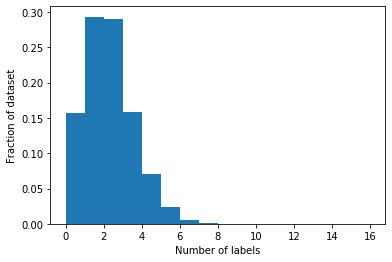

In [53]:
import matplotlib.pyplot as plt

def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

We see that around half of our train dataset data points have 2 or fewer labels from LFs. Fortunately, the signal we do have can be used to train a classifier over the comment text directly, allowing it to generalize beyond what we've specified via our LFs.

# Label Model

In [57]:
# Compared against Y_test - actual values of L
L_test = applier.apply(df_ts.rdd)

In [62]:
L_test.shape

(691, 14)

In [63]:
Y_test.shape

(691,)

In this section we use LabelModel presented by spark which (as documentation) claims to produce probablity-aware labels to train the further classification model. However, comparison between Label Model and Majority Vote is also provided.

In [58]:
from snorkel.labeling import MajorityLabelVoter

majority_model = MajorityLabelVoter(cardinality = 3)
preds_train = majority_model.predict(L = L_train)

majority_acc = majority_model.score(L=L_test, Y=Y_test, tie_break_policy="random")["accuracy"]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

Majority Vote Accuracy:   70.8%


In [73]:
from snorkel.labeling import LabelModel

label_model = LabelModel(cardinality=3, verbose=True)
label_model.fit(L_train, n_epochs=100, log_freq=100, seed=11)

label_model_acc = label_model.score(L=L_test, Y=Y_test, tie_break_policy="random")["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 51 is different from 42)

From the above Label Model performs better in labelling test split. (NOTE from Max - n_epochs affect Label model). Cardinality = number of labels.

In [ ]:
# get bucket or something here, some explanations for analysis

In [69]:
from snorkel.analysis import get_label_buckets

probs_val = majority_model.predict_proba(L=L_val)
preds_val = probs_val >= 0.5

In [71]:
preds_val.shape

(368, 3)

In [72]:
df_v.show()

+--------------------+--------------------+---------+
|               title|         des_stemmed|num_label|
+--------------------+--------------------+---------+
|           aloo gobi|tradit indian dis...|        0|
|andreas dal for i...|india dal mean nu...|        0|
|black pepper goat...|black peppercorn ...|        0|
|bombay chicken wings|chicken wing ligh...|        0|
|butternut squash ...|butternut squash ...|        0|
|chaat  dahi batat...|fragrant aromat d...|        0|
|chicken roti from...|fragrant homemad ...|        0|
|chickpea coconut ...|garbanzo bean get...|        0|
|    cilantro chutney|green chile peppe...|        0|
|creamy cashew chi...|marin curri rub c...|        0|
|cucumber peanut s...|fresh delici cucu...|        0|
|     easy curry rice|rice side dish re...|        0|
|four seasons chic...|hot sweet sour fr...|        0|
|fruited tofu curr...|vegetarian tofu s...|        0|
|  goan pork vindaloo|tradit goan pork ...|        0|
|gobi masala cauli...|small 

In [68]:
from snorkel.analysis import get_label_buckets

probs_val = majority_model.predict_proba(L=L_val)
preds_val = probs_val >= 0.5
buckets = get_label_buckets(Y_v, preds_val[:, 1])

df_fn_val = df_v[["text", "label"]].iloc[buckets[(, )]]
df_fn_val["probability"] = probs_dev[buckets[(SPAM, HAM)], 1]

df_fn_dev.sample(5, random_state=3)

NameError: name 'preds_dev' is not defined

# Training a classifier